# **FINAL PROJECTS 2 - PHASE 2**

<hr>

## **2. Import Libraries**

In [165]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import pickle
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten, GRU
from keras import optimizers
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import mplfinance as fplt

pd.options.mode.chained_assignment = None

In [166]:
colors = sns.color_palette("Set2")
colors2 = sns.color_palette("Paired")
sns.set_style("whitegrid")
plt.style.use('seaborn-pastel')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## **3. Data Loading**

### 3.1. Data Loading

In [167]:
df = pd.read_csv('historical_prices/BTCUSDT_1h_2021_2022.csv', index_col=0)

In [168]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1612137600000,33092.97,33106.33,32296.16,32546.27,4383.926122,1612141199999,1.427372e+08,98763,2074.600069,6.750233e+07,0
1,1612141200000,32546.32,33560.90,32476.34,33430.29,3713.649492,1612144799999,1.229016e+08,76863,1958.691774,6.482048e+07,0
2,1612144800000,33425.19,33830.00,33222.88,33649.73,3694.931629,1612148399999,1.241016e+08,70196,2026.270613,6.804863e+07,0
3,1612148400000,33646.37,33776.81,33470.00,33573.97,2882.141795,1612151999999,9.689886e+07,65467,1502.164716,5.050666e+07,0
4,1612152000000,33573.25,33943.55,33423.43,33558.25,3206.054328,1612155599999,1.079852e+08,82376,1739.632601,5.861244e+07,0


### 3.2. Rename Columns

In [169]:
df= df.rename(columns={'0': 'open_time', '1':'open', '2':'high', '3':'low', '4':'close', '5':'volume', '6': 'close_time', '7': 'quote_asset_volume', '8': 'number_of_trades', '9': 'taker_buy_asset_volume', '10': 'taker_buy_quote_asset_volume', '11': 'ignore'})

## **4. Exploratory Data Analysis**

## **5. Data Preprocessing**

In [170]:
df['MA5'] = df['close'].rolling(window=5).mean()

In [171]:
# df = df.loc[:, ['close', 'MA5']]

### 5.1. Split Dataset

In [172]:
# Split data into train and test

train_data_length = len(df) - 168

data_train = df.iloc[:train_data_length]
X_test = df.iloc[train_data_length:]

In [173]:
# Split train set into train and validation

train_data_length = math.ceil(data_train.shape[0] * 0.9)

X_train = data_train.iloc[:train_data_length]
X_val = data_train.iloc[train_data_length:]

### 5.2. Drop First NaN

In [174]:
X_train.dropna(inplace=True)

### 5.3. Feature Selection

In [175]:
X_train_selected = X_train.loc[:, ['close', 'MA5'] ]
X_val_selected = X_val.loc[:, ['close', 'MA5'] ]
X_test_selected = X_test.loc[:, ['close', 'MA5'] ]

### 5.4. Feature Scaling

In [176]:
scaler = RobustScaler()
scaler.fit(X_train_selected)

X_train_scaled = scaler.transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)
X_test_scaled = scaler.transform(X_test_selected)

### 5.5. Feature Extraction

#### 5.5.1. Add Time Steps Into Features

In [177]:
sequence_length = 5

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i, :]) 
        y.append(data[i, 0]) 
    
    x = np.array(x)
    y = np.array(y)
    return x, y
    

In [178]:
X_train_final, y_train = partition_dataset(sequence_length, X_train_scaled)
X_val_final, y_val = partition_dataset(sequence_length, X_val_scaled)
X_test_final, y_test = partition_dataset(sequence_length, X_test_scaled)


#### 5.5.2. Distribution Shape Check

In [179]:
print(X_train_final.shape, y_train.shape, X_test_final.shape, y_test.shape)

(8992, 5, 2) (8992,) (163, 5, 2) (163,)


## **6. Build Model**

In [180]:
base_model = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# Model

base_model.add(layers.SimpleRNN(5, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
base_model.add(layers.SimpleRNN(2, return_sequences=True))
base_model.add(layers.SimpleRNN(1))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 30; batch_size = 128; patience = 6;

base_model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

# early_stop = EarlyStopping(monitor='loss', 
#                            patience=patience, 
#                            verbose=0)

base_model.summary()

timesteps: 5, features: 2, neurons: 10
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 5, 5)              40        
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 5, 2)              16        
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 1)                 4         
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


In [181]:
parameter_list = ['epochs: ' + str(epochs), 'batch_size: ' + str(batch_size), 'patience: ' + str(patience), 'optimizer: ' + str(optimizer), 'loss: ' + str(loss)]
print('Parameters: ' + str(parameter_list))

Parameters: ['epochs: 30', 'batch_size: 128', 'patience: 6', 'optimizer: adam', 'loss: mean_squared_error']


In [182]:
base_model_hist = base_model.fit(
                    X_train_final,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=[X_val_final, y_val],
                    verbose=1
                )

Epoch 1/30


2022-04-04 13:22:16.159752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - ETA: 0s - loss: 0.2604 - mean_squared_error: 0.2604

2022-04-04 13:22:21.506188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 6s 71ms/step - loss: 0.2604 - mean_squared_error: 0.2604 - val_loss: 0.0520 - val_mean_squared_error: 0.0520
Epoch 2/30
71/71 [==============================] - 4s 59ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 3/30
71/71 [==============================] - 4s 59ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/30
71/71 [==============================] - 4s 61ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/30
71/71 [==============================] - 5s 69ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 6/30
71/71 [==============================] - 4s 60ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 7/30
71/71 [===========================

## **7. Base Model Evaluation**

### 7.1. Create Baseline Evaluation

In [183]:
evaluation_metrics = pd.DataFrame({'Model':[], 'Details' : [], 'MSE': [], 'RMSE': [], 'MAE(Test)': [], 'MAPE(Test)': [], 'Real MAE(Test)': []})
# evaluation_metrics.style.format({'RMSE(Test)': '{:.2f} $'})

In [184]:
y_pred_base = X_val_final[: -1, :, 0]
y_pred_test = X_test_final[: -1, :, 0]
# y_pred_test = scaler.inverse_transform(y_pred_test.reshape)
y_pred_base = y_pred_base.reshape(y_pred_base.shape[0], y_pred_base.shape[1], 1)
y_pred_test = y_pred_test.reshape(y_pred_test.shape[0], y_pred_test.shape[1], 1)
# calculate mse and rmse
mse_last_value = np.mean(tf.keras.losses.mean_squared_error(y_val, y_pred_base))
rmse_last_value = np.sqrt(mse_last_value)
mae_last_value_test = np.mean(tf.keras.metrics.mean_absolute_error(y_test, y_pred_test))

# calculate MAE of real price
y_test_reshape = y_test.reshape(-1, 1)
y_test_real = np.concatenate([y_test_reshape, y_test_reshape], axis=1)
y_test_real = scaler.inverse_transform(y_test_real)
y_test_real = y_test_real[:, 0]

y_pred_test_real = y_pred_test.reshape(-1, 1)
y_pred_test_real = np.concatenate([y_pred_test_real, y_pred_test_real], axis=1)
y_pred_test_real = scaler.inverse_transform(y_pred_test_real)
y_pred_test_real = y_pred_test_real[:, 0]
y_pred_test_real = y_pred_test_real.reshape(162, 5, 1)
mape_last_value_test = np.mean(tf.keras.metrics.mean_absolute_percentage_error(y_test, y_pred_test))
real_mae_last_value_test = np.mean(np.abs(y_test_real - y_pred_test_real))
evaluation_metrics.loc[0] = ['Naive Forecasting', 'Difference of Last Value in X val with y val', mse_last_value, rmse_last_value, mae_last_value_test, mape_last_value_test, real_mae_last_value_test]

### 7.2. Base Model Evaluation

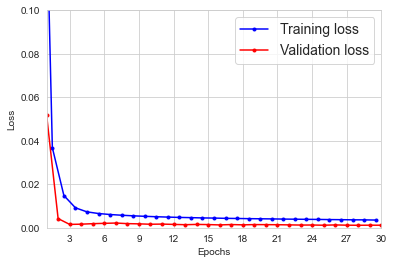

In [185]:
# Visualization of Training Loss and Validation Loss

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, epochs, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(base_model_hist.history["loss"], base_model_hist.history["val_loss"])
plt.show()

In [186]:
mse_base_deep_rnn = base_model.evaluate(X_val_final, y_val)
rmse_base_deep_rnn = np.sqrt(mse_base_deep_rnn)

32/32 [==============================] - 1s 18ms/step - loss: 0.0012 - mean_squared_error: 0.0012


In [187]:
y_pred_test_base = base_model.predict(X_test_final)
mae_base_deep_rnn_test = mean_absolute_error(y_test, y_pred_test_base)

# MAE of real price
y_pred_test_base_real = np.concatenate([y_pred_test_base, y_pred_test_base], axis=1)
y_pred_test_base_real = scaler.inverse_transform(y_pred_test_base_real)
y_pred_test_base_real = y_pred_test_base_real[:, 0]

mape_base_deep_rnn_test = np.mean(np.mean(np.abs(y_test_real - y_pred_test_base_real)/y_test_real)*100)
real_mae_base_deep_rnn_test = mean_absolute_error(y_test_real, y_pred_test_base_real)
evaluation_metrics.loc[1] = ['Base Deep RNN', 'Neuron=5, Timestep=5, Epoch=35, Multi Layers', mse_base_deep_rnn[0], rmse_base_deep_rnn[0], mae_base_deep_rnn_test, mape_base_deep_rnn_test, real_mae_base_deep_rnn_test]
evaluation_metrics

2022-04-04 13:24:26.464411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test),MAPE(Test),Real MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033678,0.183516,0.092372,520.576985,1486.098801
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001184,0.034406,0.023111,0.801556,371.818729


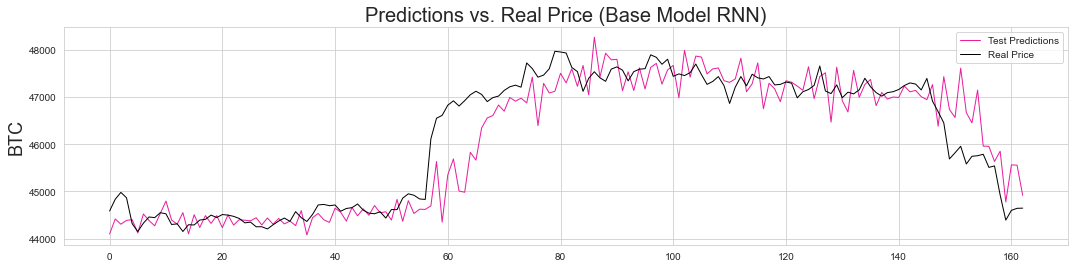

In [188]:
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (Base Model RNN)", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_test_base_real, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")

# valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
# valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
# plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

## **8. Model Improvement**

### 8.1. LSTM 

In [189]:
lstm_imp_model_2 = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The lstm_imp_model_2
lstm_imp_model_2.add(LSTM(10, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
lstm_imp_model_2.add(LSTM(2))
lstm_imp_model_2.add(Dense(1, activation='linear'))

# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 75; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

lstm_imp_model_2.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

lstm_imp_model_2.summary()

timesteps: 5, features: 2, neurons: 10
Parameters: ['epochs 75', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 10)          520       
                                                                 
 lstm_5 (LSTM)               (None, 2)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 627
Trainable params: 627
Non-trainable params: 0
_________________________________________________________________


In [190]:
lstm_imp_model_hist_2 = lstm_imp_model_2.fit(
                    X_train_final,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final, y_val),
                    verbose=0
                )

2022-04-04 13:24:28.907590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:24:29.165520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:24:29.239031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:24:29.379204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:24:29.476867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:24:33.055265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:24:33.142647: I tensorflow/core/grappler/optimizers/cust

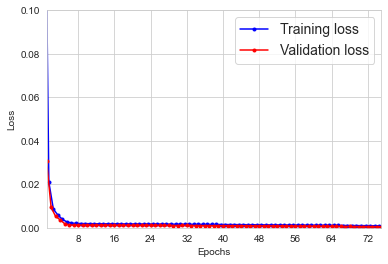

In [191]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(lstm_imp_model_hist_2.history["loss"], lstm_imp_model_hist_2.history["val_loss"])
plt.show()

In [192]:
mse_lstm_imp_rnn_2 = lstm_imp_model_2.evaluate(X_val_final, y_val)
rmse_lstm_imp_rnn_2 = np.sqrt(mse_lstm_imp_rnn_2)

32/32 [==============================] - 0s 11ms/step - loss: 5.0500e-04 - mean_squared_error: 5.0500e-04


In [193]:
y_pred_lstm_non = lstm_imp_model_2.predict(X_test_final)
mae_lstm_imp_rnn_2_test = mean_absolute_error(y_test, y_pred_lstm_non)

# MAE of real price
y_pred_lstm_non_real = np.concatenate([y_pred_lstm_non, y_pred_lstm_non], axis=1)
y_pred_lstm_non_real = scaler.inverse_transform(y_pred_lstm_non_real)
y_pred_lstm_non_real = y_pred_lstm_non_real[:, 0]

mape_pred_imp_rnn_2 = np.mean(np.mean(np.abs(y_test_real - y_pred_lstm_non_real)/y_test_real)*100)
real_mae_pred_imp_rnn_2 = mean_absolute_error(y_test_real, y_pred_lstm_non_real)
evaluation_metrics.loc[2] = ['LSTM - Non-Pipeline Dataset', 'Without tensorflow pipeline dataset. The rest is same', mse_lstm_imp_rnn_2[0], rmse_lstm_imp_rnn_2[0], mae_lstm_imp_rnn_2_test, mape_pred_imp_rnn_2, real_mae_pred_imp_rnn_2]
evaluation_metrics

2022-04-04 13:25:23.277112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:25:23.340913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:25:23.413306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test),MAPE(Test),Real MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033678,0.183516,0.092372,520.576985,1486.098801
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001184,0.034406,0.023111,0.801556,371.818729
2,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000505,0.022472,0.011532,0.402458,185.529217


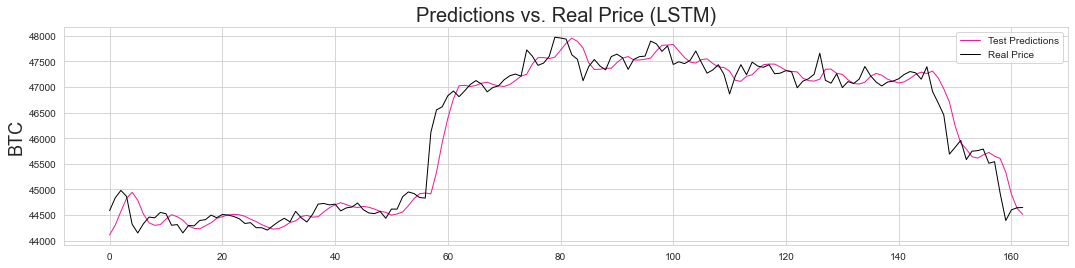

In [194]:
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM)", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_non_real, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")

# valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
# valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
# plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

### 8.2. GRU

In [195]:
gru_imp_model = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The gru_imp_model
gru_imp_model.add(GRU(10, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
gru_imp_model.add(GRU(2))
gru_imp_model.add(Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 75; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

gru_imp_model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=patience, 
                           verbose=0)

gru_imp_model.summary()

timesteps: 5, features: 2, neurons: 10
Parameters: ['epochs 75', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, None, 10)          420       
                                                                 
 gru_7 (GRU)                 (None, 2)                 84        
                                                                 
 dense_6 (Dense)             (None, 1)                 3         
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________


In [196]:
gru_imp_model_hist = gru_imp_model.fit(
                    X_train_final,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final, y_val),
                    verbose=0
                )

2022-04-04 13:25:25.649843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:25:25.858870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:25:25.951045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:25:26.128049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:25:26.377645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:25:27.507689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:25:27.572862: I tensorflow/core/grappler/optimizers/cust

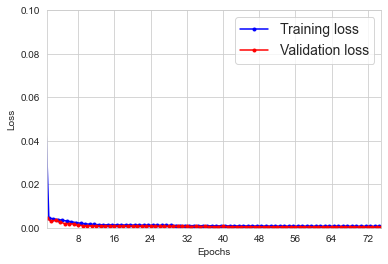

In [197]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(gru_imp_model_hist.history["loss"], gru_imp_model_hist.history["val_loss"])
plt.show()

In [198]:
mse_gru_imp_rnn = gru_imp_model.evaluate(X_val_final, y_val)
rmse_gru_imp_rnn = np.sqrt(mse_gru_imp_rnn)

32/32 [==============================] - 0s 9ms/step - loss: 3.8074e-04 - mean_squared_error: 3.8074e-04


In [199]:
y_pred_gru_non = gru_imp_model.predict(X_test_final)
mae_gru_imp_test = mean_absolute_error(y_test, y_pred_gru_non)

# MAE of real price
y_pred_gru_non_real = np.concatenate([y_pred_gru_non, y_pred_gru_non], axis=1)
y_pred_gru_non_real = scaler.inverse_transform(y_pred_gru_non_real)
y_pred_gru_non_real = y_pred_gru_non_real[:, 0]

mape_pred_gru_test = np.mean(np.mean(np.abs(y_test_real - y_pred_gru_non_real)/y_test_real)*100)
real_mae_pred_gru_test = mean_absolute_error(y_test_real, y_pred_gru_non_real)
evaluation_metrics.loc[3] = ['GRU - Non-Pipeline Dataset', 'Without tensorflow pipeline dataset. The rest is same', mse_gru_imp_rnn[0], rmse_gru_imp_rnn[0], mae_gru_imp_test, mape_pred_gru_test, real_mae_pred_gru_test]
evaluation_metrics

2022-04-04 13:26:12.684607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:26:12.742714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:26:12.778952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test),MAPE(Test),Real MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033678,0.183516,0.092372,520.576985,1486.098801
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001184,0.034406,0.023111,0.801556,371.818729
2,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000505,0.022472,0.011532,0.402458,185.529217
3,GRU - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000381,0.019513,0.009845,0.342969,158.390480


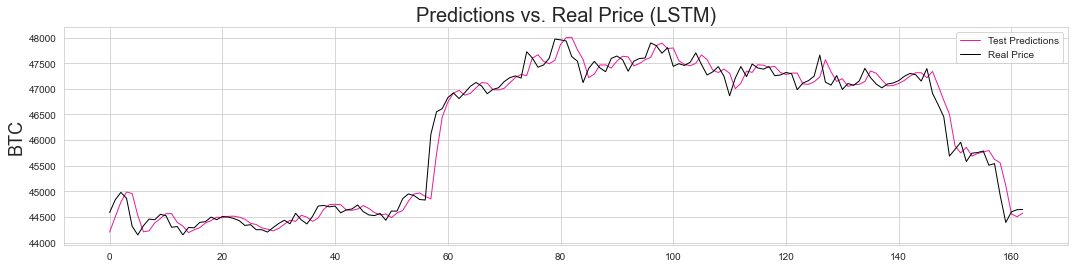

In [200]:
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM)", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_gru_non_real, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")

plt.show()

### 8.3. LSTM More Sequence Length

In [217]:
sequence_length = 50

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i, :]) 
        y.append(data[i, 0]) 
    
    x = np.array(x)
    y = np.array(y)
    return x, y

X_train_final_2, y_train_2 = partition_dataset(sequence_length, X_train_scaled)
X_val_final_2, y_val_2 = partition_dataset(sequence_length, X_val_scaled)
X_test_final_2, y_test_2 = partition_dataset(sequence_length, X_test_scaled)

    

In [218]:
lstm_24_seq = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The lstm_24_seq
lstm_24_seq.add(GRU(10, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
lstm_24_seq.add(GRU(5))
lstm_24_seq.add(Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 50; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

lstm_24_seq.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

lstm_24_seq.summary()

timesteps: 5, features: 2, neurons: 10
Parameters: ['epochs 50', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, None, 10)          420       
                                                                 
 gru_13 (GRU)                (None, 5)                 255       
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


In [219]:
lstm_24_seq_hist = lstm_24_seq.fit(
                    X_train_final_2,
                    y_train_2,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final_2, y_val_2),
                    verbose=0
                )

2022-04-04 13:29:59.136124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:29:59.347585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:29:59.604129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:29:59.721066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:30:00.191146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:30:03.179486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:30:03.248668: I tensorflow/core/grappler/optimizers/cust

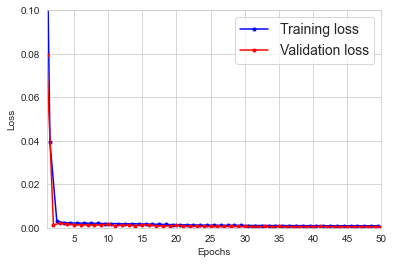

In [220]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(lstm_24_seq_hist.history["loss"], lstm_24_seq_hist.history["val_loss"])
plt.show()

In [221]:
mse_lstm_24_seq = lstm_24_seq.evaluate(X_val_final_2, y_val_2)
rmse_lstm_24_seq = np.sqrt(mse_lstm_24_seq)

30/30 [==============================] - 1s 16ms/step - loss: 5.2123e-04 - mean_squared_error: 5.2123e-04


In [222]:
y_test_2_real = y_test_2.reshape(-1, 1)
y_test_2_real = np.concatenate([y_test_2_real, y_test_2_real], axis=1)
y_test_2_real = scaler.inverse_transform(y_test_2_real)
y_test_2_real = y_test_2_real[:, 0]

In [223]:
y_pred_lstm_24 = lstm_24_seq.predict(X_test_final_2)
mae_lstm_24_seq = mean_absolute_error(y_test_2, y_pred_lstm_24)

# MAE of real price
y_pred_lstm_24_real = np.concatenate([y_pred_lstm_24, y_pred_lstm_24], axis=1)
y_pred_lstm_24_real = scaler.inverse_transform(y_pred_lstm_24_real)
y_pred_lstm_24_real = y_pred_lstm_24_real[:, 0]

mape_pred_lstm_24 = np.mean(np.mean(np.abs(y_test_2_real - y_pred_lstm_24_real)/y_test_2_real)*100)
real_mae_pred_lstm_24 = mean_absolute_error(y_test_2_real, y_pred_lstm_24_real)
evaluation_metrics.loc[4] = ['LSTM - 24 Sequence Length', 'Timestep=50, without tensorflow pipeline dataset. The rest is same', mse_lstm_24_seq[0], rmse_lstm_24_seq[0], mae_lstm_24_seq, mape_pred_lstm_24, real_mae_pred_lstm_24]
evaluation_metrics

2022-04-04 13:31:32.652244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:31:32.720916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:31:32.797767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test),MAPE(Test),Real MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033678,0.183516,0.092372,520.576985,1486.098801
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001184,0.034406,0.023111,0.801556,371.818729
2,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000505,0.022472,0.011532,0.402458,185.529217
3,GRU - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000381,0.019513,0.009845,0.342969,158.390480
4,LSTM - 24 Sequence Length,"Timestep=50, without tensorflow pipeline datas...",0.000521,0.022830,0.012263,0.422887,197.293831


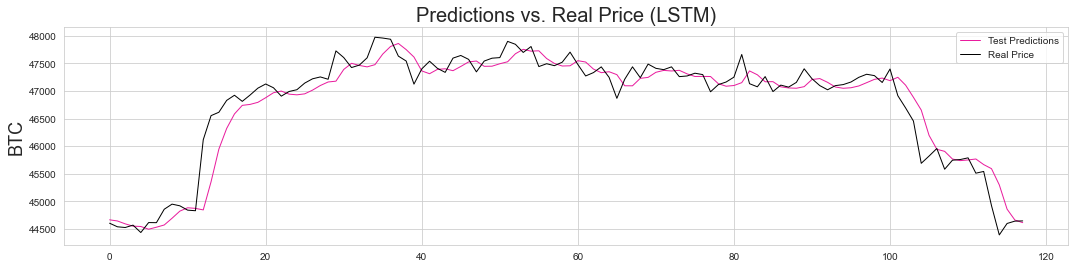

In [224]:
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM)", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_24_real, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_2_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")

plt.show()

## **10. Model Saving**

### 10.1. Choose The Best Model

In [228]:
y_dummy_price = []
for i in range(0, 45):
    y_dummy_price.append(43000)
    
y_pred_lstm_24_compare = y_pred_lstm_24_real.reshape(-1, 1)
y_pred_lstm_24_compare = np.insert(y_pred_lstm_24_compare, 0, np.array(y_dummy_price).reshape(-1,1), axis=0)

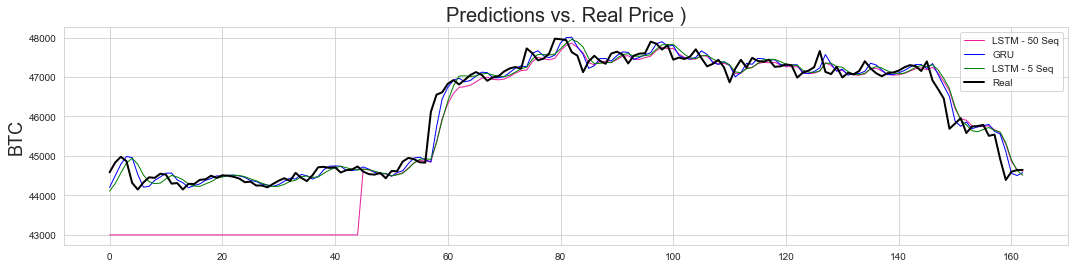

In [229]:
# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price )", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_24_compare, color="#E91D9E", linewidth=1.0)
plt.plot(y_pred_gru_non_real, color="blue", linewidth=1.0)
plt.plot(y_pred_lstm_non_real, color="green", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=2.0)
plt.legend(["LSTM - 50 Seq", "GRU", "LSTM - 5 Seq", "Real"], loc="upper right")
plt.show()

### 10.2. Scaling Pipeline

In [231]:
with open("save_models/scale_pipe_2_features.pkl", "wb") as f:
    pickle.dump(scaler, f)

### 10.3. Save Deep Learning Model

In [232]:
# save model
lstm_24_seq.save('save_models/lstm_24_2_features.h5')
print('Model Saved!')

Model Saved!


In [233]:
# save model
gru_imp_model.save('save_models/gru_5_2_features.h5')
print('Model Saved!')

Model Saved!
